# Stage 1

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

In [ ]:
tickers = ['AMAT','NXPI']
df = yf.download(tickers,start='2020-01-01')['Close']
rolling_window = 21*12 #One year has roughly 252 trading days so this is a 1 year rolling window. Or, 21 days per month
stock1,stock2 = tickers

/var/folders/mz/5wx8rb615dgcw9z8x127yfr40000gn/T/ipykernel_69160/119855505.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers,start='2020-01-01')['Close']
[*********************100%***********************]  2 of 2 completed


#Spread by Rishav Patel

#Why?
#Spread is an important feature because it will tell us the difference between the historical linear relationship (calculated using linear regression) and the current relationship. In essence it is the difference between stock1's actual value and stock2's predicted value using a a coefficient beta and a intercept alpha which were obtained through linear regression. We can use spread to find out when the two stocks are diverging, which is an opportunity for profit.

#How?
#Using a rolling window of 252, we grab 252 days of prices between two stocks, fit them to a line of best fit such that stock1 predicts stock2, and then calculate spread for this rolling window by subtracting the actual value of stock 2 from the value of (stock1*coefficient + intercept). We then repeat this process by grabbing a new rolling window except we shift the window by 1 (in a for loop). The loop continues until the rolling window is iterated all the way to the latest price and a rolling spread has been calculated for every day.

#Missing Values
#Because we are using a window of 252, we automatically lack the data necessary to begin generating rolling data for the first 251 days of the dataset. This data will be used for rolling spread of later days but the rolling spread for that data cannot be computed. Hence we remove these rows from our data.

#Code:
#Rolling alpha is the intercept for each window and rolling beta is the coefficient for each window, obtained by linear regression. We calculate it like so:


Missing values in spread:
 252

First 10 values of spread:
 Date
2020-12-31    -7.015283
2021-01-04    -4.988936
2021-01-05    -6.089324
2021-01-06    -5.151407
2021-01-07    -5.434355
2021-01-08    -6.845830
2021-01-11   -12.227218
2021-01-12   -12.447798
2021-01-13    -7.453726
2021-01-14   -17.383731
dtype: float64


<Axes: title={'center': 'Spread'}, xlabel='Date'>

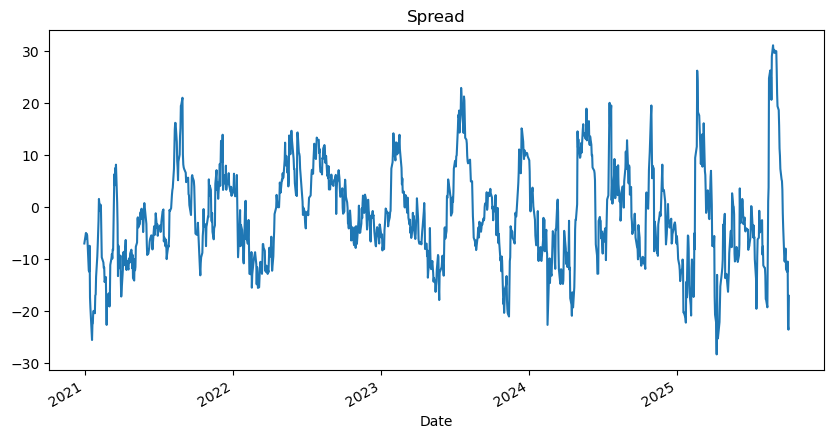

In [ ]:
rolling_alpha = [np.nan] * rolling_window
rolling_beta = [np.nan] * rolling_window
for i in range(rolling_window, len(df)):
    past_data = df.iloc[i-rolling_window:i]

    X = past_data[stock1].values
    y = past_data[stock2].values
    X = sm.add_constant(X)

    model = sm.OLS(y,X).fit()
    rolling_alpha.append(model.params[0])
    rolling_beta.append(model.params[1])
rolling_params = pd.DataFrame({'Rolling Alpha':rolling_alpha,'Rolling Beta':rolling_beta},index=df.index)

#Calculates the spread of the data.
spread = df[stock2] - (rolling_params['Rolling Alpha'] + rolling_params['Rolling Beta'] * df[stock1])

#Check to see how many missing values exist
print("\nMissing values in spread:\n",spread.isnull().sum())

#Check the first 10 valid values to ensure it runs
spread = spread.dropna()
print("\nFirst 10 values of spread:\n",spread.head(10))

#Plot for spread
spread.plot(title="Spread", figsize = (10,5))

#RollingMean by Jared Martinez

#Why?
I calculated the rolling mean of the spread between AMAT and NXPI. The rolling mean smooths out short-term noise in the spread and shows its underlying trend, helping investors see if the relationship is drifting or reverting. This insight can guide better timing and strategy decisions.

#How?  * use a sliding  window to computer the average sprea at each step  * Shift the window by 1 day at a time to generate a rollign sequence of mean values. * this provides a time seris of moving averages that track the central tendency of the spread

#Missing values the first window -1 rows cannot be comouted and are dropped because a rolling mean requires enough data equal to the window size

#Code

In [ ]:
rolling_mean = spread.rolling(rolling_window).mean()

#RollingSD by Angel Lopez

##Why?
#For my feature, I did the rolling standard deviation of the spread between AMAT and NXPI for stock finance
#Spread is the difference between NXPI's actual value and AMAT's predicted value. Rolling SD measures the fluctuation of the spread (how big the spread is aka volatility).
#Volatility is used to judge the risk of investing at any given point, helping investors determine when it's best to invest.

#How?
#Via the data, weuse a rolling windows of a year of trading (about 252 days).
#Rolling SD is calculated each day based on the past 252 days worth of spread data. The greater the value, the greater volatility

#Missing Values?
#Missing values are handled by setting the first 251 rows with NaN. In "ml_data = pd.DataFrame(){...}", rows with NaN are dropped. Upon hitting row 252, we have usable data. In practice, we just go to each row until 252, which would be our first and by that point only row with data, so we don't have 252 rows then, just 1.

#Code:


First 10 values of Rolling SD:
 Date
2020-12-31   NaN
2021-01-04   NaN
2021-01-05   NaN
2021-01-06   NaN
2021-01-07   NaN
2021-01-08   NaN
2021-01-11   NaN
2021-01-12   NaN
2021-01-13   NaN
2021-01-14   NaN
dtype: float64

Missing values in rolling_std:
 251


<Axes: title={'center': 'Rolling SD of Spread'}, xlabel='Date'>

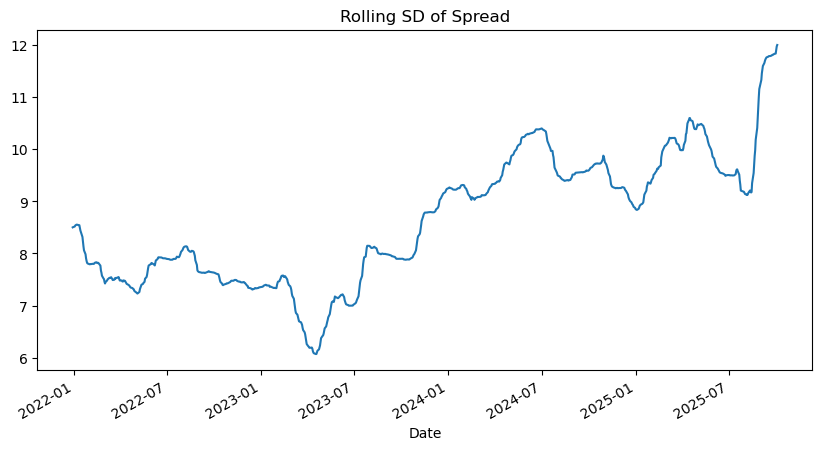

In [ ]:
#Calculates the Rolling SD of the data Spread
rolling_std = spread.rolling(rolling_window).std()

#Check the first 10 values to ensure it runs
print("\nFirst 10 values of Rolling SD:\n", rolling_std.head(10))

#Check to see how many missing values exist
print("\nMissing values in rolling_std:\n", rolling_std.isnull().sum())

#Plot for Rolling SD
rolling_std.plot(title="Rolling SD of Spread", figsize=(10,5))

#Sajid-Z-score

#Why? Z-score is an important feature because it tells us how many standard deviations the current spread is away from its historical mean. Unlike spread (absolute divergence) and rolling SD (volatility), z-score standardizes the spread, making it possible to compare deviations at different times on the same scale.

#Missing Values: Each rolling feature (Spread, Rolling SD, Z-Score) could introduce missing values in the first 251 rows because a full 252-day window is required. These rows are dropped from the dataset to ensure all features align and remain usable.

#How? We use the rolling mean and rolling standard deviation of the spread (over a 252-day window) to calculate z-score for each day. We calculate this for each day starting at index 252. Like spread and rolling SD, the first 251 rows will be missing values

#Z-score calculation


Missing values in z_score:
 251

First 10 values of z_score:
 Date
2021-12-30    0.746974
2021-12-31    0.710590
2022-01-03    0.808393
2022-01-04    1.130405
2022-01-05    0.686039
2022-01-06    0.655358
2022-01-07    0.608340
2022-01-10    0.775760
2022-01-11    1.073747
2022-01-12    0.448789
dtype: float64


<Axes: title={'center': 'Z-Score of Spread'}, xlabel='Date'>

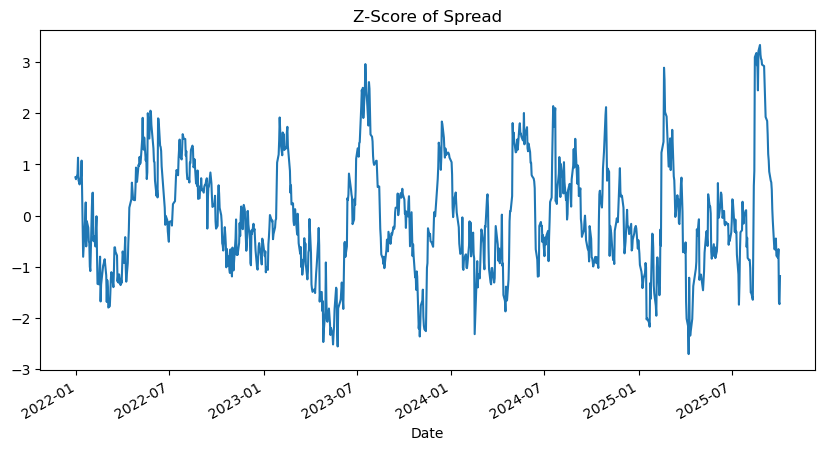

In [ ]:
z_score = (spread - rolling_mean) / rolling_std
#Check to see how many missing values exist
print("\nMissing values in z_score:\n", z_score.isnull().sum())
#Check the first 10 valid values to ensure it runs
z_score = z_score.dropna()
print("\nFirst 10 values of z_score:\n", z_score.head(10))
#Plot z-score
z_score.plot(title="Z-Score of Spread", figsize=(10,5))

In [ ]:
ml_data = pd.DataFrame({'spread':spread,
                        'rolling mean':rolling_mean,
                        'rolling std':rolling_std,
                        'z-score': z_score}, index = df.index)
ml_data = ml_data.dropna()

In [ ]:
ml_data

,spread,rolling mean,rolling std,z-score
Date,,,,
2021-12-30,2.996758,-3.352647,8.500169,0.746974
2021-12-31,2.730023,-3.313976,8.505606,0.710590
2022-01-03,3.604469,-3.279875,8.516084,0.808393
2022-01-04,6.418977,-3.230239,8.536073,1.130405
2022-01-05,2.661767,-3.199234,8.543253,0.686039
...,...,...,...,...
2025-09-29,-12.488942,-2.739313,11.832209,-0.823991
2025-09-30,-10.494917,-2.741022,11.833302,-0.655260
2025-10-01,-22.934180,-2.818280,11.901408,-1.690212


# Stage 2

## Task 1a

In [ ]:
import scipy.stats as stats
import pandas as pd

features = ['spread', 'rolling mean', 'rolling std']

stats_summary = {}

for feature in features:
    data = ml_data[feature]
    stats_summary[feature] = {
        'Mean': data.mean(),
        'Median': data.median(),
        'Variance': data.var(),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data)  # Fisher: 0 = normal
    }

stats_df = pd.DataFrame(stats_summary).T
stats_df

,Mean,Median,Variance,Skewness,Kurtosis
spread,-1.198757,-2.219983,94.261778,0.394830,0.234332
rolling mean,-0.963914,-0.872909,1.988478,0.118334,-0.648980
rolling std,8.628691,8.758856,1.534043,0.238251,-0.611044


## Task 1b

| Feature       | Type      | Continuous or Discrete |
|---------------|-----------|-------------------------|
| spread        | Numerical | Continuous              |
| rolling mean  | Numerical | Continuous              |
| rolling std   | Numerical | Continuous              |

All selected features are **numerical and continuous**. They can take any real value within a range rather than fixed integers, which makes them continuous variables. None of the selected variables are categorical.

## Task 2a

**Spread** feature was selected for Task 2a. Since the spread fluctuates around zero and takes both positive and negativ values, it behaves like a stationary, mean-reverting financlial series which is assumed to follow a **Nornal Distribution**

## Task 2b

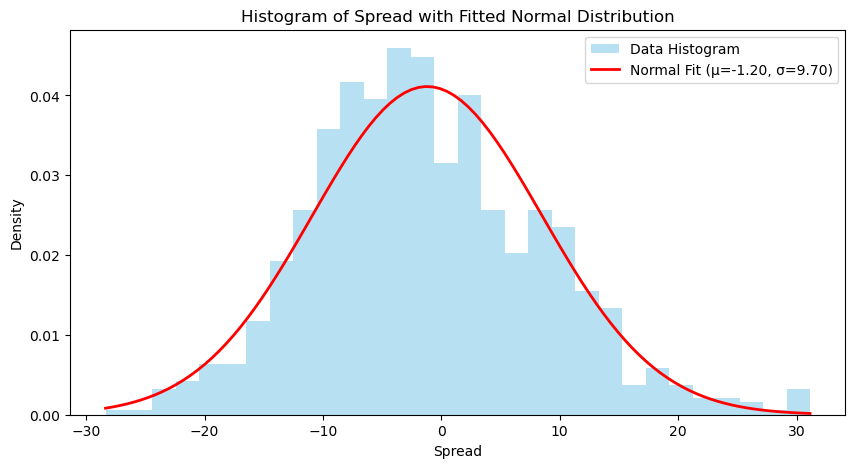

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

data = ml_data['spread']

# Fit a normal distribution
mu, sigma = norm.fit(data)

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Data Histogram')

# Create x-axis for curve
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

# Plot fitted normal curve
plt.plot(x, p, 'r', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')

plt.title('Histogram of Spread with Fitted Normal Distribution')
plt.xlabel('Spread'); plt.ylabel('Density')
plt.legend()
plt.show()

The Histogram shows that the spread is roughly centered around zero, and the fitted Normal curve captures the central mass of the distribution resonably well.

## Task 3a

In [ ]:
# Population statistics
population_mean = data.mean()
population_variance = data.var()

print(f"Population Mean: {population_mean:.4f}")
print(f"Population Variance: {population_variance:.4f}")

sample_1 = data.sample(100, random_state=1)

sample_mean_1 = sample_1.mean()
sample_variance_1 = sample_1.var()

print("\n--- Sample 1 (100 samples) ---")
print(f"Sample Mean: {sample_mean_1:.4f}")
print(f"Sample Variance: {sample_variance_1:.4f}")

Population Mean: -1.1988
Population Variance: 94.2618

--- Sample 1 (100 samples) ---
Sample Mean: -0.6003
Sample Variance: 98.4037


## Task 3b

In [ ]:
# Repeat sampling 3 times with different seeds
sample_means = []
sample_variances = []

for i in range(3):
    sample = data.sample(100, random_state=i+1)
    sample_means.append(sample.mean())
    sample_variances.append(sample.var())
    print(f"\n--- Sample {i+1} ---")
    print(f"Sample Mean: {sample.mean():.4f}")
    print(f"Sample Variance: {sample.var():.4f}")


--- Sample 1 ---
Sample Mean: -0.6003
Sample Variance: 98.4037

--- Sample 2 ---
Sample Mean: -0.3177
Sample Variance: 115.7306

--- Sample 3 ---
Sample Mean: -0.7408
Sample Variance: 97.0164


These values are all close to the population mean but they do vary slightly due to randomness  similarly the sample variance varies between "97.0164" and "115.7306" Even though the samples differ they remian centered around the true population values

## Task 4

Correlation Matrix:
                spread  rolling mean  rolling std
spread        1.000000      0.093656     0.034174
rolling mean  0.093656      1.000000    -0.587888
rolling std   0.034174     -0.587888     1.000000


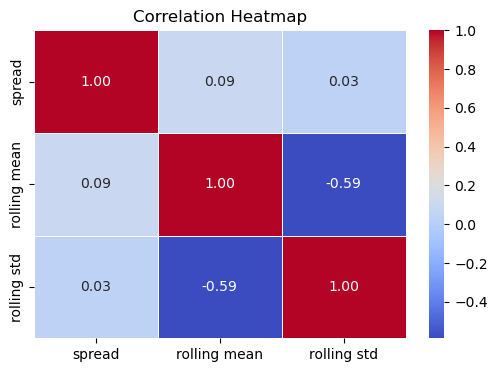

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select features for correlation
corr_data = ml_data[['spread', 'rolling mean', 'rolling std']]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

The correlation matrix shows that spread and rolling mean have a very weak positive correlation of .09. Spread and Rolling standard deviation have an even weaker psotive correlation of .03 suggesting almost no lineary relationship. the strongest relationship is Rolling mean and standard deviation.


In [ ]:
### Task 5
# Creating some Hypotheses

# Based on the work done in tasks 1 through 4, we have come up with the following hypotheses:

# 1) Periods with higher Rolling SD will have higher mean absolute Z-Score values
  #  - Z-score values are expected to increase when the Rolling SD coincides with larger mean deviations
  #  - How we may test: we can compute the correlation

# 2) Absolute Rolling Mean is positively correlated with Rolling SD
#    - Volatility increases with an increasing mean magnitude
#    - How we may test: Correlation analysis between the Rolling Mean and Rolling SD

# 3) Spread is positively correlated with Rolling SD
#    - Higher volatility implies higher spread, which in turn creates more uncertainity in the data
#    - How we may test: Correlation between Spread and Rolling SD should give a solid result

**Task 5** - Creating some Hypotheses

Based on the work done in tasks 1 through 4, we have come up with the following hypotheses:

**1) Periods with higher Rolling SD will have higher mean absolute Z-Score values**
- Z-Scores are expected to increase when the Rolling SD coincides with larger mean deviations

How we may test: we can compute the correlation

**2) Absolute Rolling Mean is positively correlated with Rolling SD**
- Volatility increases with an increasing mean magnitude

How we may test: Correlation analysis between the Rolling Mean and Rolling SD

**3) Spread is positively correlated with Rolling SD**
- Higher volatility implies higher spread, which in turn creates more uncertainity in the data

How we may test: Correlation between Spread and Rolling SD should give a solid result